In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/Store Sales")

In [7]:
df = pd.read_csv('train.csv')

In [8]:
# Transformar a coluna de data em datetime
df['date'] = pd.to_datetime(df['date'])

# Remover 2017-08 da análise pois não é um mês completo
mask_1708 = df['date'].dt.strftime('%Y-%m').str.startswith('2017-08')
df = df[~mask_1708]

# Coluna de ano, trimestre e mês
df['ano'] = df['date'].dt.year 
df['mes'] = df['date'].dt.month 
df['dia'] = df['date'].dt.day 
df['trimestre'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str)).dt.to_period('Q')

# Adicionando id por grupo de ano e mês
df['yyyy_mm'] = df['ano'].astype(str) + '-' + df['mes'].astype(str)

# Transformando coluna string em int 'family'
mapeamento_valores_family = {}

for i, valor in enumerate(df['family'].unique()):
    mapeamento_valores_family[valor] = i

df['ft_family'] = df['family'].map(mapeamento_valores_family)

# Transformando coluna string em int 'trimestre'
mapeamento_valores_trimestre = {}

for i, valor in enumerate(df['trimestre'].unique()):
    mapeamento_valores_trimestre[valor] = i

df['trimestre_id'] = df['trimestre'].map(mapeamento_valores_trimestre)

# Range de datas
print("Data mínima:", df['date'].min())
print("Data máxima:", df['date'].max())

Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-07-31 00:00:00


In [9]:
# Renomear colunas para identificar as features ft_ e target tg_
renomear_colunas = {
    'store_nbr': 'ft_store',
    'onpromotion': 'ft_onpromotion',
    'ano': 'ft_ano',
    'mes': 'ft_mes',
    'dia': 'ft_dia',
    'sales': 'tg_sales'
}

df.rename(columns=renomear_colunas, inplace=True)

df.head()

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,ft_dia,trimestre,yyyy_mm,ft_family,trimestre_id
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,2013Q1,2013-1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,2013Q1,2013-1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,2013Q1,2013-1,2,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,2013Q1,2013-1,3,0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,2013Q1,2013-1,4,0


In [10]:
# Vamos separar o último trimestre para teste
df_teste = df[df['trimestre'] == '2017Q3']
df_teste.shape

(55242, 13)

In [11]:
# Separando os dados que sobraram para tv (treino e validação)
df_tv = df[df['trimestre'] != '2017Q3']
df_tv.shape

(2918916, 13)

# TESTE

In [44]:
# Holdout 50-50
df_treino = df_tv[df_tv['trimestre'] <= '2017Q1']
df_validacao = df_tv[df_tv['trimestre'] > '2017Q1']
print('Treino:', df_treino.shape, df_treino['trimestre'].unique())
print('Validação:', df_validacao.shape, df_validacao['trimestre'].unique())

Treino: (2756754, 13) <PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1']
Length: 17, dtype: period[Q-DEC]
Validação: (162162, 13) <PeriodArray>
['2017Q2']
Length: 1, dtype: period[Q-DEC]


In [45]:
X_train = df_treino.filter(regex = r'ft_')
X_val = df_validacao.filter(regex = r'ft_')
y_train = df_treino['tg_sales']
y_val = df_validacao['tg_sales'] 

In [59]:
resultado_val = []

for iteration in range(1, 18):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] < iteration ]
    val = df_tv[df_tv['trimestre_id'] == iteration]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 10, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 10000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4305

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4341

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4196

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4122

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4359

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4448

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4552

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4468

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4594

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4800

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4708

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4788

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4507

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

## Validando com o df de teste

In [60]:
df_teste.head(2)

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,ft_dia,trimestre,yyyy_mm,ft_family,trimestre_id
2918916,2918916,2017-07-01,1,AUTOMOTIVE,7.0,0,2017,7,1,2017Q3,2017-7,0,18
2918917,2918917,2017-07-01,1,BABY CARE,0.0,0,2017,7,1,2017Q3,2017-7,1,18


In [61]:
X_test = df_teste.filter(regex = r'ft_')
y_test = df_teste['tg_sales']

In [62]:
df_predicao = pd.Series(modelo.predict(X_test), index=X_test.index, name='pd_sales')
df_predicao = pd.concat((X_test, df_predicao), axis=1)
df_predicao.head()

,ft_store,ft_onpromotion,ft_ano,ft_mes,ft_dia,ft_family,pd_sales
2918916,1,0,2017,7,1,0,-54.545984
2918917,1,0,2017,7,1,1,-56.623386
2918918,1,1,2017,7,1,2,42.765136
2918919,1,27,2017,7,1,3,2689.230644
2918920,1,0,2017,7,1,4,-56.594116


In [63]:
df_concat = pd.merge(df_teste, df_predicao, left_index=True, right_index=True)

In [64]:
df_concat.head()

,id,date,ft_store_x,family,tg_sales,ft_onpromotion_x,ft_ano_x,ft_mes_x,ft_dia_x,trimestre,yyyy_mm,ft_family_x,trimestre_id,ft_store_y,ft_onpromotion_y,ft_ano_y,ft_mes_y,ft_dia_y,ft_family_y,pd_sales
2918916,2918916,2017-07-01,1,AUTOMOTIVE,7.0,0,2017,7,1,2017Q3,2017-7,0,18,1,0,2017,7,1,0,-54.545984
2918917,2918917,2017-07-01,1,BABY CARE,0.0,0,2017,7,1,2017Q3,2017-7,1,18,1,0,2017,7,1,1,-56.623386
2918918,2918918,2017-07-01,1,BEAUTY,7.0,1,2017,7,1,2017Q3,2017-7,2,18,1,1,2017,7,1,2,42.765136
2918919,2918919,2017-07-01,1,BEVERAGES,2596.0,27,2017,7,1,2017Q3,2017-7,3,18,1,27,2017,7,1,3,2689.230644
2918920,2918920,2017-07-01,1,BOOKS,0.0,0,2017,7,1,2017Q3,2017-7,4,18,1,0,2017,7,1,4,-56.594116


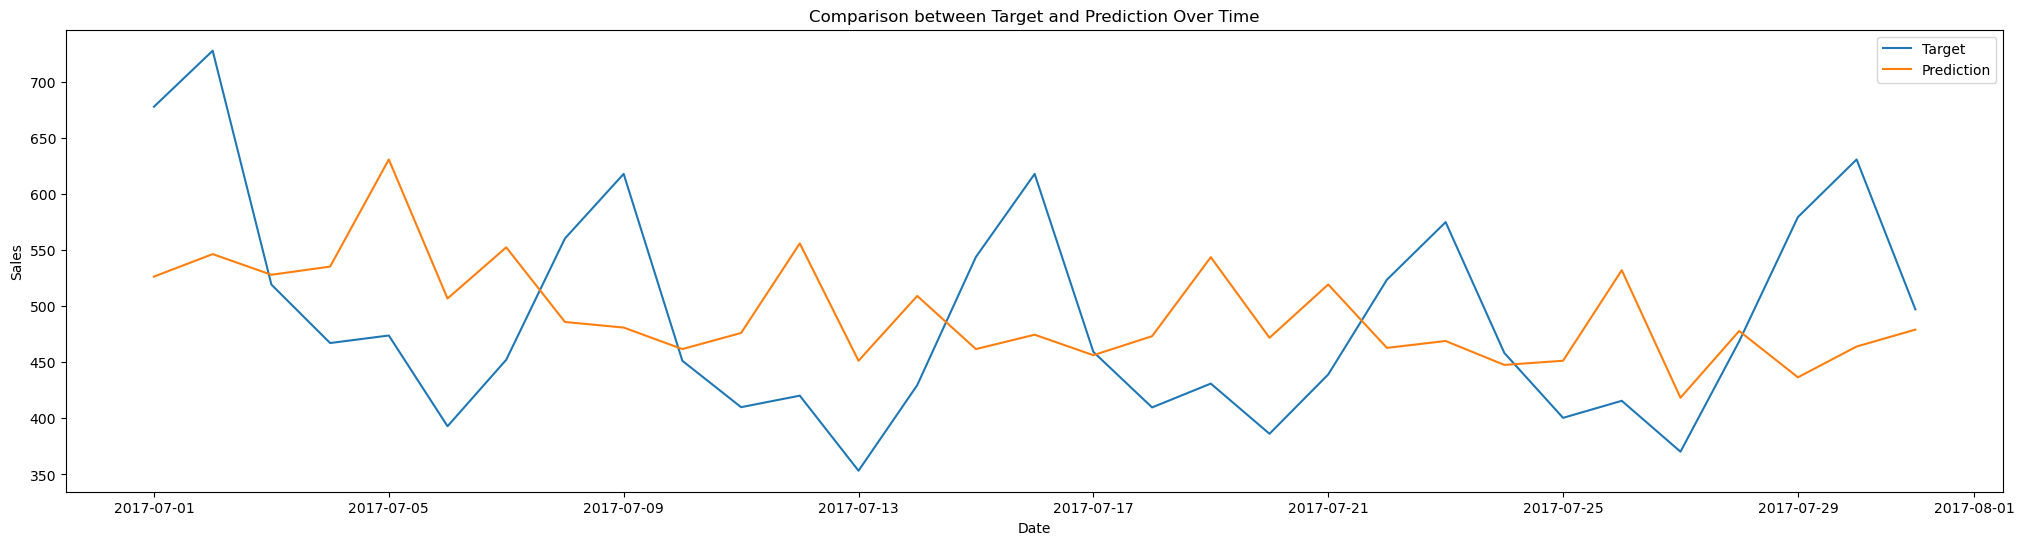

In [65]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=df_concat, x='date', y='tg_sales', label='Target', ci=None)
sns.lineplot(data=df_concat, x='date', y='pd_sales', label='Prediction', ci=None)
plt.title('Comparison between Target and Prediction Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [66]:
correlation = np.corrcoef(df_concat['tg_sales'], df_concat['pd_sales'])[0, 1]
correlation

0.8043026666431742

# sMAPE

In [67]:
# Define the function to return the SMAPE value 
def calculate_smape(actual, predicted) -> float: 
  
    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), 
        np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2) 
        )*100, 2
    ) 

In [70]:
# Get SMAPE for pandas series as parameters 
calculate_smape(df_concat['tg_sales'], df_concat['pd_sales'])

ValueError: not enough values to unpack (expected 2, got 1)